# PLATEAU-FloodSAR: 0 準備
ケース名と解析の領域を設定し、対応する建物データと標高データを準備します。

ケース名のサブディレクトリが作成され、結果はそこに保存されます。

解析の領域の緯度経度は世界測地系（[EPSG:6668](https://epsg.io/6668), [JGD2011](https://maps.gsi.go.jp/help/howtouse.html#h2-3)）です。[国土地理院地図](https://maps.gsi.go.jp/)から取得してください。

解析の領域を含むzoomレベル15の標高データの準備をします。

解析の領域内の建物データを抽出します。

パラメータを設定した上でメニューバーのランタイム＞全てのセルを実行してください。


広域だと全ての処理が終わるのに小一時間ほどかかることもあります。

以前と同じ地域について解析する場合は、ケース名のサブディレクトリを作成し、そこに以前のboundary.jsonとbuildings_prsed.jsonをコピーすることで、この手順を省略することができます。


In [2]:
# @title Googleドライブの準備
from google.colab import drive
import warnings

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# @title 設定するパラメータ

# ケース名：解析を通して使います。
casename = "kurume-r2"

# 分析する領域のGeoJSON（ファイルが存在しない場合は次の「分析する領域」が有効）
boundaryfile = ""# "kurume.geojson"

# 分析する領域：複数の領域の配列。ひとつの領域は[経度,緯度] の配列。
# （先の「分析する領域のGeoJSON」のファイルが存在する場合は上書きされます。）
# 最初と最後の [経度,緯度] が異なる場合、自動的に領域を閉じます。

init_boundaries = [
    [
      [130.41249721501615, 33.224722548534864],
      [130.41249721501615, 33.348],
      [130.59, 33.348],
      [130.59, 33.224722548534864],
      [130.41249721501615, 33.224722548534864]
    ]
]

#init_boundaries = [
#    [
#      [130.378532,33.214563],
#      [130.763741,33.214563],
#      [130.763741,33.406511],
#      [130.378532,33.406511],
#      [130.378532,33.214563]
#    ]
#]

# 大牟田市
#init_boundaries = [
#  [
#    [130.383110, 32.991771],
#    [130.545845, 32.991771],
#    [130.545845, 33.103334],
#    [130.383110, 33.103334],
#    [130.383110, 32.991771]
#  ]
#]
# CityGMLのダウンロード元のURL
url_CityGML = "https://assets.cms.plateau.reearth.io/assets/d6/70821e-7f58-4f69-bc34-341875704e78/40203_kurume-shi_2020_citygml_3_op.zip" # URL of the cityGML zip file
#filename_CityGML = "40202_omuta-shi_2023_citygml_1.zip" # name of the file in CityGML directory
flg_from_web = True # set True if you use file in CityGML directory

In [4]:
# @title 詳細設定用パラメータ（基本的には操作不要）

enable_savefig = False # 図をGoogleドライブに保存する？

zoomlevel = 15 # DEM zoom level to fetch

# デバッグ用出力
global globalflag_debug

# 保存先
path_home = "/content/drive/MyDrive/plateau-2023-uc01-satellite-analytics/PLATEAU-FloodSAR/"
path_cgml = "/tmp/" # path_home + "/CityGML/"
path_dem = path_home + "/DEM/"
path_case = path_home + casename + "/"
json_buildings = path_case+"buildings_parsed.json"
json_boundary = path_case +"boundary.json"
file_bbox = path_case + "boundbox.npy"
file_dem_fmt = path_case + "dem_{}_{}-{}_{}-{}.npz"
if not flg_from_web:
  file_CityGML = path_home + "CityGML/" + filename_CityGML

## 各種読み込み

In [5]:

!pip install --upgrade numpy
!pip install --upgrade scikit-image
!pip install geojson
!pip install plateauutils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 28.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 29.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.19.3
    Uninstalling scikit-image-0.19.3:
      Successfully uninstalled scikit-image-0.19.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 414.4/414.4 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.6/151.6 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.1 MB/s eta 0:00:00
  Created wheel for earcut: filename=earcut-1.1.5-py3-none-any.whl size=8738 sha256=d7e09c26a8be9827af7ee638c2c2374fa739842adebb9ee54bd7e44999

In [6]:
# @title 主要ライブラリインポート
import numpy as np
import math
import requests
import os
import geojson
from progressbar import progressbar
from shapely import box
import matplotlib.pyplot as plt
import sys
sys.path.append(path_home)
import plateau_floodsar_lib as pfsl

In [7]:
# @title 基本的な関数

def coordinates_to_rect(coordinates):
  #coordinates = coordinates[0]

  lon_min = min(coordinates, key=lambda x: x[0])[0]
  lon_max = max(coordinates, key=lambda x: x[0])[0]
  lat_min = min(coordinates, key=lambda x: x[1])[1]
  lat_max = max(coordinates, key=lambda x: x[1])[1]
  # rasterio bounds tuple (left, bottom, right, top)
  # https://rasterio.readthedocs.io/en/stable/api/rasterio.coords.html
  return (lon_min, lat_min, lon_max, lat_max)

## 実行

In [8]:
# @title ディレクトリ準備

if os.path.exists(path_case):
  print(f"{casename}のディレクトリは既に存在しています。内容が上書きされます。")
  #warnings.warn("The destination exists already. It will be overwritten.")
else:
  print(f"{casename}のディレクトリを作成しました。全ての結果はこの中に保存されます。")
  os.mkdir(path_case)

if not os.path.exists(path_cgml):
  os.mkdir(path_cgml)

kurume-r2のディレクトリは既に存在しています。内容が上書きされます。


In [9]:
#@title 領域の初期設定と保存
boundaries_json = []

#print(path_home+boundaryfile)
if os.path.isfile(path_home+boundaryfile):
  print("loading: ", boundaryfile)
  with open(path_home+boundaryfile,"r") as ifile:
    tmp = geojson.load(ifile)
    print(tmp)
    try:
      if tmp["type"] == 'FeatureCollection':
        tmp = tmp['features']
    except:
      pass
    print(tmp)
    try:
      for ii,vv in enumerate(tmp):
        if vv["type"] == 'Feature':
          tmp[ii] = vv['geometry']
    except:
      pass
    print(tmp)
    for vv in tmp:
      boundaries_json.append(geojson.Polygon(vv["coordinates"]))

else:
  for ii, boundary in enumerate(init_boundaries):
    if boundary[0] != boundary[-1]:
      boundary.append(boundary[0])
    boundaries_json.append(geojson.Polygon([boundary]))

#[{"type": "Polygon", "coordinates": [[[

#boundary_polygon = geojson.Polygon(boundaries)
#print(geojson.dumps(boundaries_json))
#print(geojson.loads(geojson.dumps(boundaries_json)))
with open(json_boundary, "w") as ofile:
  ofile.write(geojson.dumps(boundaries_json))
print(f"{json_boundary} に領域が保存されました。")

/content/drive/MyDrive/plateau-2023-uc01-satellite-analytics/PLATEAU-FloodSAR/kurume-r2/boundary.json に領域が保存されました。


In [10]:
#@title 最外領域の初期
boundary_pts = []
with open(json_boundary) as ifile:
  txt = ifile.read()
  print(txt)
  tmp = geojson.loads(txt)
  for vv in tmp:
    for pp in vv["coordinates"]:
      boundary_pts.extend(pp)
print(boundary_pts)
boundbox = coordinates_to_rect(boundary_pts)
del boundary_pts
print(boundbox)

[{"type": "Polygon", "coordinates": [[[130.412497, 33.224723], [130.412497, 33.348], [130.59, 33.348], [130.59, 33.224723], [130.412497, 33.224723]]]}]
[[130.412497, 33.224723], [130.412497, 33.348], [130.59, 33.348], [130.59, 33.224723], [130.412497, 33.224723]]
(130.412497, 33.224723, 130.59, 33.348)


In [11]:
# @title 建物データのパース　：  *久留米のほぼ全域だと24分かかります。*

from shapely import from_geojson
from plateauutils.parser.city_gml_parser import CityGMLParser
import shutil
import json


buildings = []

for boundary in boundaries_json:
  boundary_str = geojson.dumps(boundary)
  print(boundary_str)
  print(from_geojson(boundary_str))

  parser = CityGMLParser(from_geojson(boundary_str))
  #try:
  if flg_from_web:
    tmp = parser.download_and_parse(url_CityGML, path_cgml)
  else:
    tmp = parser.parse(file_CityGML)
  #print(tmp)
  buildings.extend(tmp)
  #except ValueError:
  #  print("No data found")


{"type": "Polygon", "coordinates": [[[130.412497, 33.224723], [130.412497, 33.348], [130.59, 33.348], [130.59, 33.224723], [130.412497, 33.224723]]]}
POLYGON ((130.412497 33.224723, 130.412497 33.348, 130.59 33.348, 130.59 33.224723, 130.412497 33.224723))


100%|██████████| 2.63G/2.63G [02:30<00:00, 17.4MiB/s]


uro:buildingStructureType is NoneType in bldg_5dd76af7-4bbb-433f-bd71-b7451226799f in 40203_kurume-shi_2020_citygml_3_op/udx/bldg/49307461_bldg_6697_op.gml


In [12]:
#@title 最外領域の再設定
# boundbox (130.411835, 33.230934, 130.695763, 33.36523)
boundbox = list(boundbox)
for bb in buildings:
  lon, lat = bb["center"]
  if lon < boundbox[0]:
    boundbox[0] = lon
  if lat < boundbox[1]:
    boundbox[1] = lat
  if boundbox[2] < lon:
    boundbox[2] = lon
  if boundbox[3] < lat:
    boundbox[3] = lat
boundbox = tuple(boundbox)
np.save(file_bbox, boundbox)

In [13]:
# @title DEMマップ取得
print(boundbox)
bbox = box(*boundbox)
print(bbox)
gdm = pfsl.GiajDemManager(path_home,dem_types = [{"type":"dem5a","z":15},{"type":"dem5b","z":15}])
gdm.load_dem_tiles(bbox)
tile = gdm.produce_tile_stiched()

(130.4000069710961, 33.224450683790295, 130.5999829054351, 33.349999879860974)
POLYGON ((130.5999829054351 33.224450683790295, 130.5999829054351 33.349999879860974, 130.4000069710961 33.349999879860974, 130.4000069710961 33.224450683790295, 130.5999829054351 33.224450683790295))


100% (19 of 19) |########################| Elapsed Time: 0:01:25 Time:  0:01:25


In [14]:
#@title 建物への標高付与と建物データの保存
for building in buildings:
  lon, lat = building["center"]
  building["dem"] = gdm.calc_dem_interp(lon,lat)
print(buildings[0])
print(f"{len(buildings)}件の建物データ")

with open(json_buildings, "w") as ofile:
  ofile.write(json.dumps(buildings, ensure_ascii=False))
print(f"{json_buildings} に建物データが保存されました。")

{'gid': 'bldg_383f1804-aa34-4634-949f-f769e09fa92d', 'center': [130.41263587199947, 33.22489181671553], 'min_height': 3.805999994277954, 'measured_height': 9.3, 'building_structure_type': '非木造', 'dem': 4.262634735297812}
84164件の建物データ
/content/drive/MyDrive/plateau-2023-uc01-satellite-analytics/PLATEAU-FloodSAR/kurume-r2/buildings_parsed.json に建物データが保存されました。


Text(0, 0.5, 'min_height')

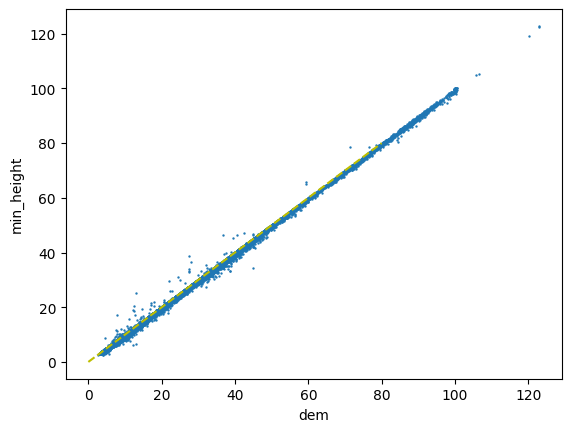

In [15]:
minhs = np.array([bb["min_height"] for bb in buildings])
dems = np.array([bb["dem"] for bb in buildings])
plt.scatter(dems, minhs, s=0.5)#, alpha=0.10)
plt.plot([0,80],[0,80], "--", c="y")
plt.xlabel("dem")
plt.ylabel("min_height")

Text(0.5, 0, 'min_height - dem')

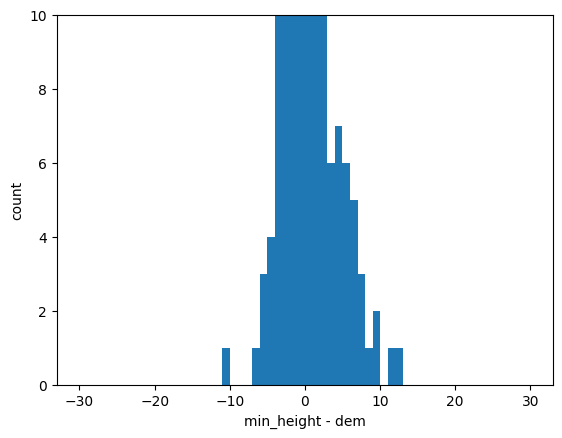

In [16]:
plt.hist(minhs-dems, bins=np.arange(-30,31,1))
plt.ylim([0,10])
plt.ylabel("count")
plt.xlabel("min_height - dem")

(130.396728515625, 130.60542583465576, 33.220343691375454, 33.35806161277886)

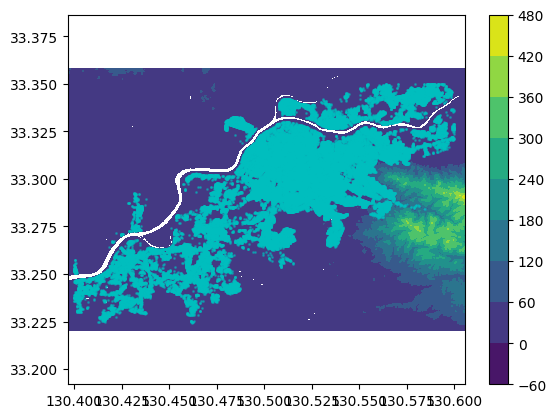

In [17]:
# @title 建物と標高のチェック
xx = [bld["center"][0] for bld in buildings]
yy = [bld["center"][1] for bld in buildings]
ax =plt.subplot(1,1,1)
img = ax.contourf(tile["lons"],tile["lats"],tile["dem"])
#img = ax.imshow(demmap)
ax.scatter(xx,yy,c="c", s=1, alpha=0.5)
plt.colorbar(img)
ax.axis("equal")